In [11]:
from lib.dataset_utils import *
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import numpy as np
import string
import wordcloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DATASET = DatasetEnum.GoEmotionsCleaned
# load dataset
train_df, val_df, test_df = load_dataset(DATASET)
LABELS = train_df.columns[1:]
TEXT_COLUMN = 'text'
CLEAN_TEXT_COLUMN = 'clean_text'

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_content(text):
    
    # convert to lowercase
    clean_text = text.lower()
    
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text.split()]

    # tokenize
    clean_text = nltk.word_tokenize(' '.join(clean_text))

    # remove punctuation marks
    clean_text = [w for w in clean_text if w not in string.punctuation]#TODO additional cleanup

    return ' '.join(clean_text)

def clean_df(df, text_col, out_col):
    df[out_col] = df[text_col].apply(clean_content)
    return df

In [4]:
CLEAN_TEXT_COLUMN = 'clean_text'
train_df = clean_df(train_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
val_df = clean_df(val_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)

In [5]:
# count words for each class
from collections import Counter
word_counter = {label: Counter() for label in LABELS}
global_prior = Counter()
for i, row in train_df.iterrows():
    for label in LABELS:
        if row[label] == 1:
            # remove duplicate tokens
            tokens = set(row[CLEAN_TEXT_COLUMN].split())
            word_counter[label].update(tokens)
            global_prior.update(tokens)

# get top 10 words for each class
top_words = {label: [word for word, _ in word_counter[label].most_common(10)] for label in LABELS}
print(top_words)

{'admiration': ['the', 'i', 'a', 'is', 'that', 'it', 'you', 'to', 'and', 'this'], 'amusement': ['lol', 'i', 'the', 'a', 'it', 'that', 'to', 'you', 'is', 'and'], 'disapproval': ['i', 'the', 'a', 'it', 'to', "n't", 'not', 'that', 'is', 'you'], 'disgust': ['the', 'i', 'is', 'a', 'it', 'that', 'and', 'to', 'this', 'of'], 'embarrassment': ['i', 'the', 'a', 'to', 'it', 'that', 'and', 'of', '’', 'is'], 'excitement': ['i', 'the', 'to', 'a', 'it', 'that', 'this', 'for', 'and', '’'], 'fear': ['i', 'the', 'a', 'that', 'to', 'is', 'it', 'of', 'and', 'this'], 'gratitude': ['you', 'thanks', 'i', 'thank', 'for', 'the', 'to', 'a', 'it', 'that'], 'grief': ['i', 'to', 'the', 'and', 'your', 'a', 'for', 'died', 'that', 'my'], 'joy': ['i', 'the', 'a', 'it', 'to', 'you', 'happy', 'and', 'that', 'glad'], 'love': ['love', 'i', 'the', 'it', 'and', 'a', 'to', 'name', 'this', 'you'], 'nervousness': ['i', 'the', 'a', 'that', 'to', 'and', 'me', 'it', 'this', 'is'], 'anger': ['the', 'i', 'you', 'a', 'to', 'and', 'i

In [6]:
# get class probability
class_prob = {label: sum(train_df[label]) / len(train_df) for label in LABELS}

In [7]:
# get vord list
vocab = set()
for label in LABELS:
    vocab.update(word_counter[label].keys())
vocab = list(vocab)

In [8]:
ALPHA = 0.75
K_SMOOTH = 0.5
pmi_matrix = np.zeros((len(vocab), len(LABELS)))
for i, word in enumerate(vocab):
    for j, label in enumerate(LABELS):
        pmi_matrix[i, j] = np.max(np.log2((word_counter[label][word] + K_SMOOTH) / np.power((global_prior[word] + K_SMOOTH), ALPHA) / class_prob[label]), 0)#TODO check

In [9]:
# get top 10 words for each class
top_words = {label: [vocab[i] for i in np.argsort(pmi_matrix[:, j])[-10:]] for j, label in enumerate(LABELS)}
for emotion in LABELS:
    print(emotion, top_words[emotion])

admiration ['fantastic', 'gorgeous', 'excellent', 'nice', 'good', 'cute', 'beautiful', 'amazing', 'awesome', 'great']
amusement ['funnier', 'laughing', 'laugh', 'lmao', 'laughed', 'hahaha', 'hilarious', 'haha', 'funny', 'lol']
disapproval ['dyscalculia', 'cog', 'fruitless', 'aub', 'distasteful', 'so-called', 'recreate', 'sham', 'unpopular', 'disagree']
disgust ['tenure…ridiculous', 'xenophobic', 'biscuits', 'infj', 'submerge', 'worst', 'hag', 'disgust', 'awful', 'disgusting']
embarrassment ['glancing', '31f', 'ashamed', 'embarrassed', 'awkward', 'embarrasing', 'embarassing', 'embarassed', 'embarrassment', 'embarrassing']
excitement ['seeeee', 'bask', 'yoohoo~', 'uplifted', '⚔️🛡', 'feeds', 'exciting', 'fournier', '🎂', 'excited']
fear ['marrow', 'scare', 'fear', 'horrified', 'petrified', 'terrified', 'scary', 'afraid', 'terrifying', 'scared']
gratitude ['feedback', 'clarifying', 'welcome', 'advice', 'recommendation', 'thankyou', 'clarification', 'sharing', 'thank', 'thanks']
grief ['zoey

Word cloud for admiration


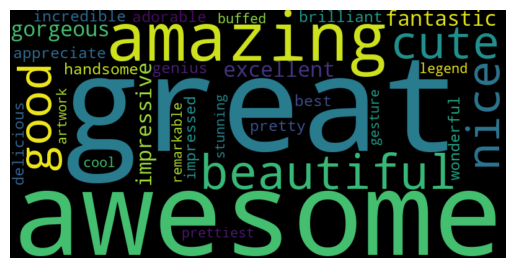

Word cloud for amusement


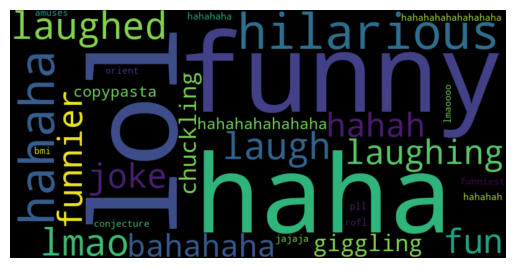

Word cloud for disapproval


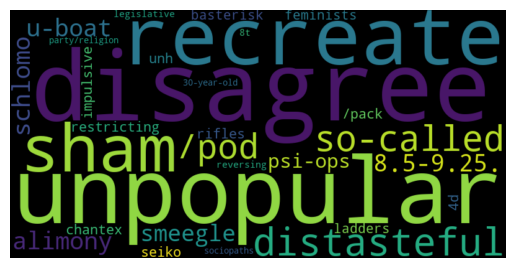

Word cloud for disgust


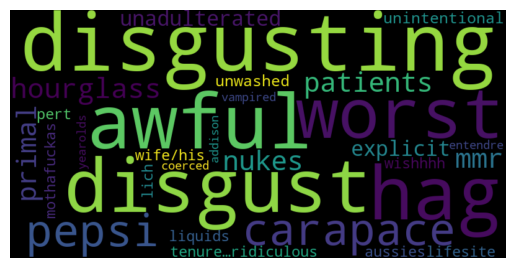

Word cloud for embarrassment


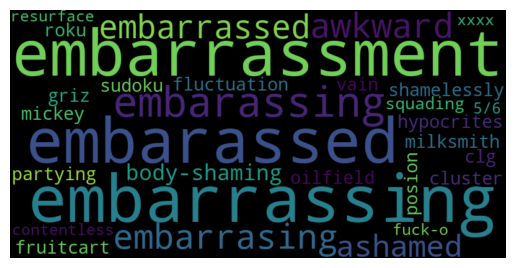

Word cloud for excitement


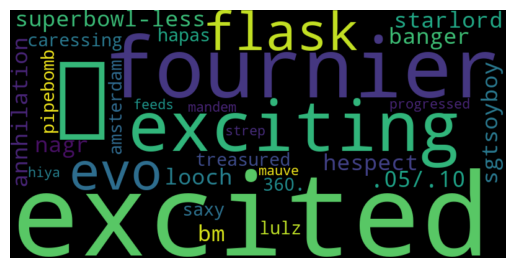

Word cloud for fear


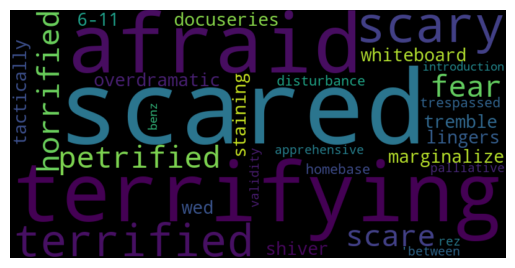

Word cloud for gratitude


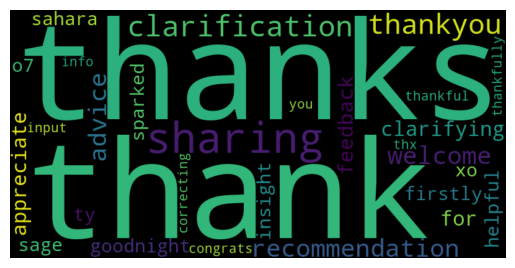

Word cloud for grief


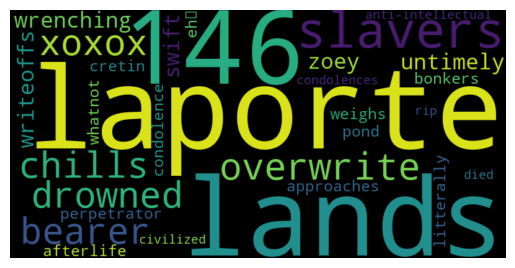

Word cloud for joy


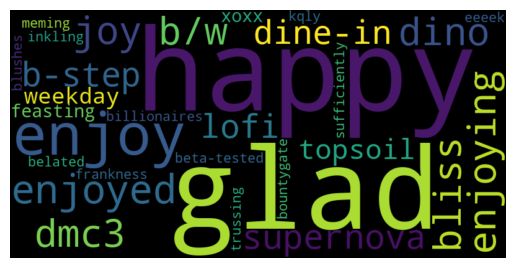

Word cloud for love


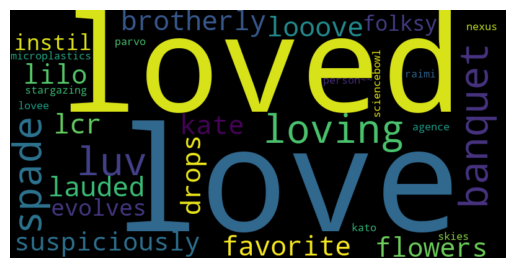

Word cloud for nervousness


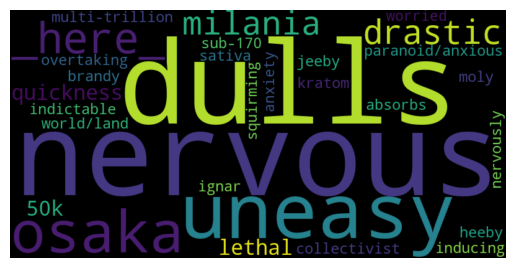

Word cloud for anger


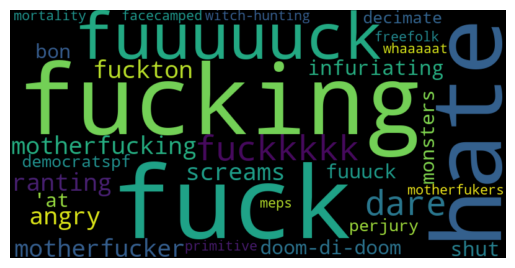

Word cloud for optimism


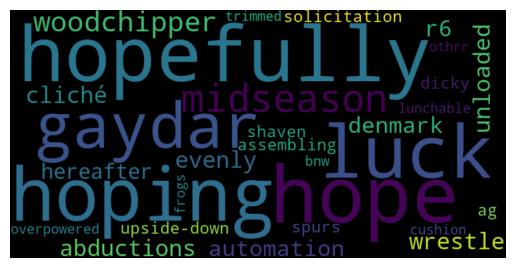

Word cloud for pride


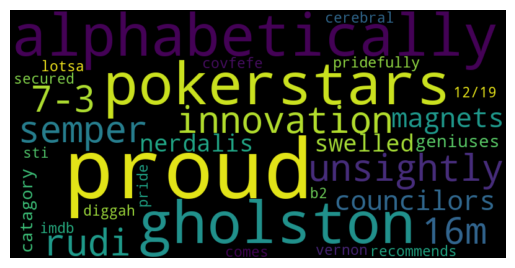

Word cloud for realization


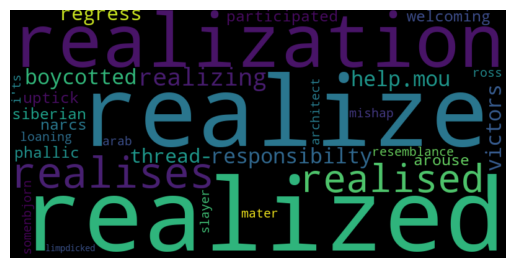

Word cloud for relief


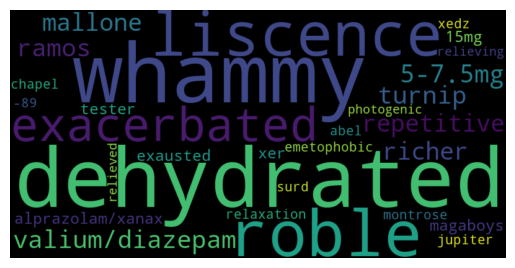

Word cloud for remorse


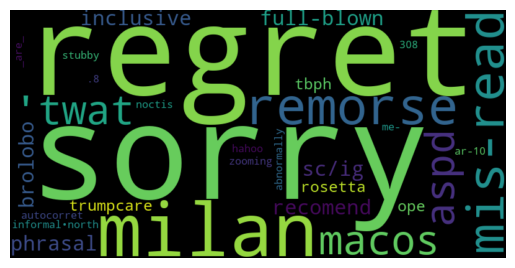

Word cloud for sadness


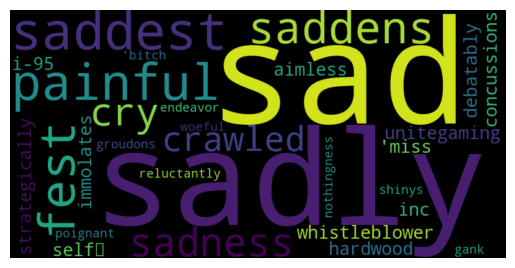

Word cloud for surprise


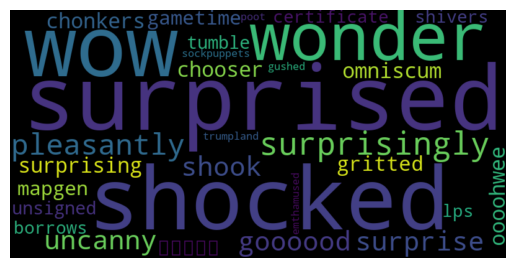

Word cloud for neutral


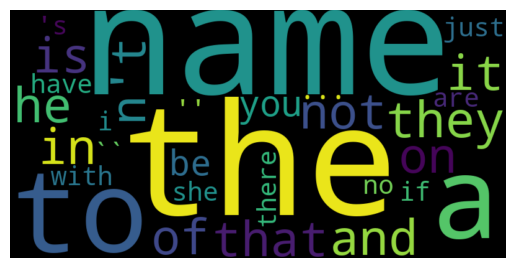

Word cloud for annoyance


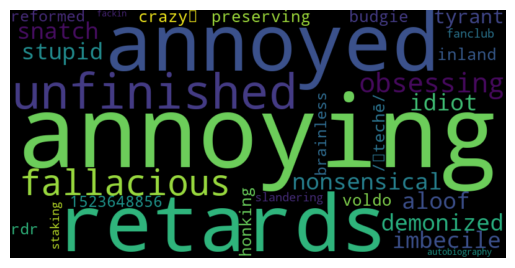

Word cloud for approval


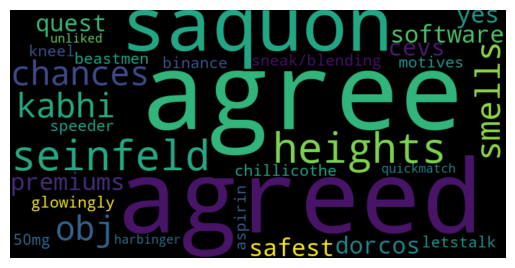

Word cloud for caring


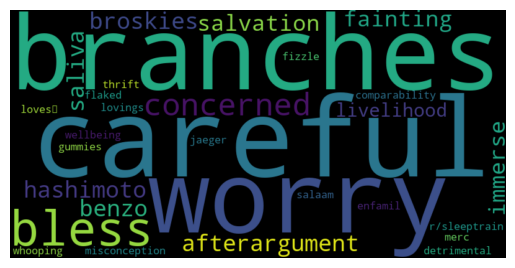

Word cloud for confusion


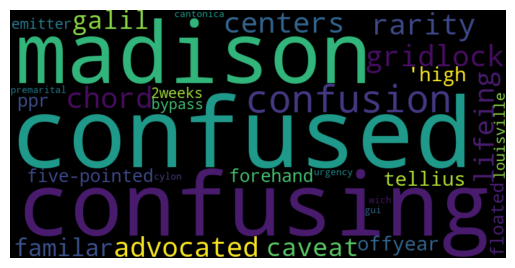

Word cloud for curiosity


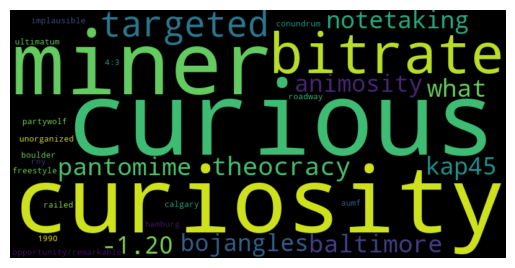

Word cloud for desire


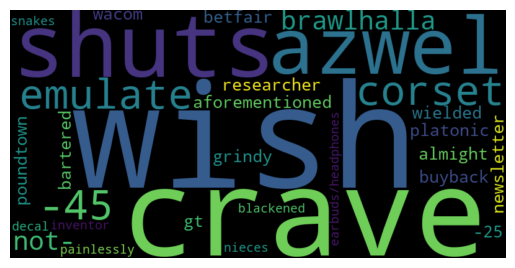

Word cloud for disappointment


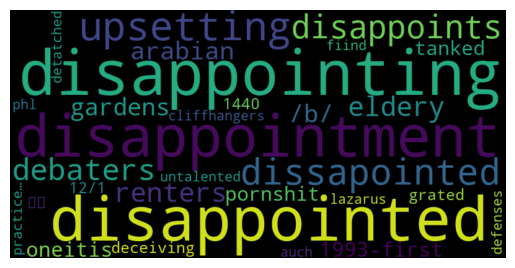

In [14]:
# word cloud of top words given scores
N_TOP = 30
for label in LABELS:
    print(f'Word cloud for {label}')
    wc = wordcloud.WordCloud(width=800, height=400, max_words=N_TOP).generate_from_frequencies({word: pmi_matrix[i, LABELS.get_loc(label)] for i, word in enumerate(vocab)})
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()